### Data Source

you can download data from https://www.kaggle.com/c/data-science-bowl-2018/data

### Code Source
 code for UNet Architecture and Making Predictions copied from the kernel shared by Minggang Chen at https://www.kaggle.com/chenmg04/u-net-for-image-segmentation/notebook
 
 I changed the activation function and Data Loading part using Generator function with ablation.
 for basic UNet Starter you can follow his kernel
 
#### Thanks to Minggang Chen for his work. it speed up my experiments.

## 1. Import libraries

In [5]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf


We set the random seed so that the results don't vary drastically.

In [6]:
np.random.seed(30)
random.seed(30)
tf.set_random_seed(30)

## 2. Explore Data
#### 2.1 Read and Plot Images functions

In [7]:
def read_image_labels(image_id):
    image_file = "../input/data-science-bowl-2018/stage1_train/{}/images/{}.png".format(image_id,image_id)
    mask_file = "../input/data-science-bowl-2018/stage1_train/{}/masks/*.png".format(image_id) 
    image = imread(image_file)
    masks = imread_collection(mask_file).concatenate()
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint16)
    
    for index in range(0, num_masks):       
        labels = np.maximum(labels, masks[index])
    
    return image, labels

def plot_images_masks(image_ids):
    plt.close('all')
    fig, ax = plt.subplots(nrows=len(image_ids),ncols=2, figsize=(50,50))
    i=0
    for ax_index, image_id in enumerate(image_ids):
        image, labels = read_image_labels(image_id)
        print("image shape:",image.shape)
        ax[i][0].imshow(image)
        ax[i][1].imshow(labels)                 
        i=i+1


#### 2.2. Plot some random images with masks

Total Images in Training set: 670
Randomly Selected Images: 2, their IDs: ['9cbc0700317361236a9fca2eb1f8f79e3a7da17b1970c179cf453921a6136001', '3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90']
image shape: (256, 256, 4)
image shape: (256, 256, 4)


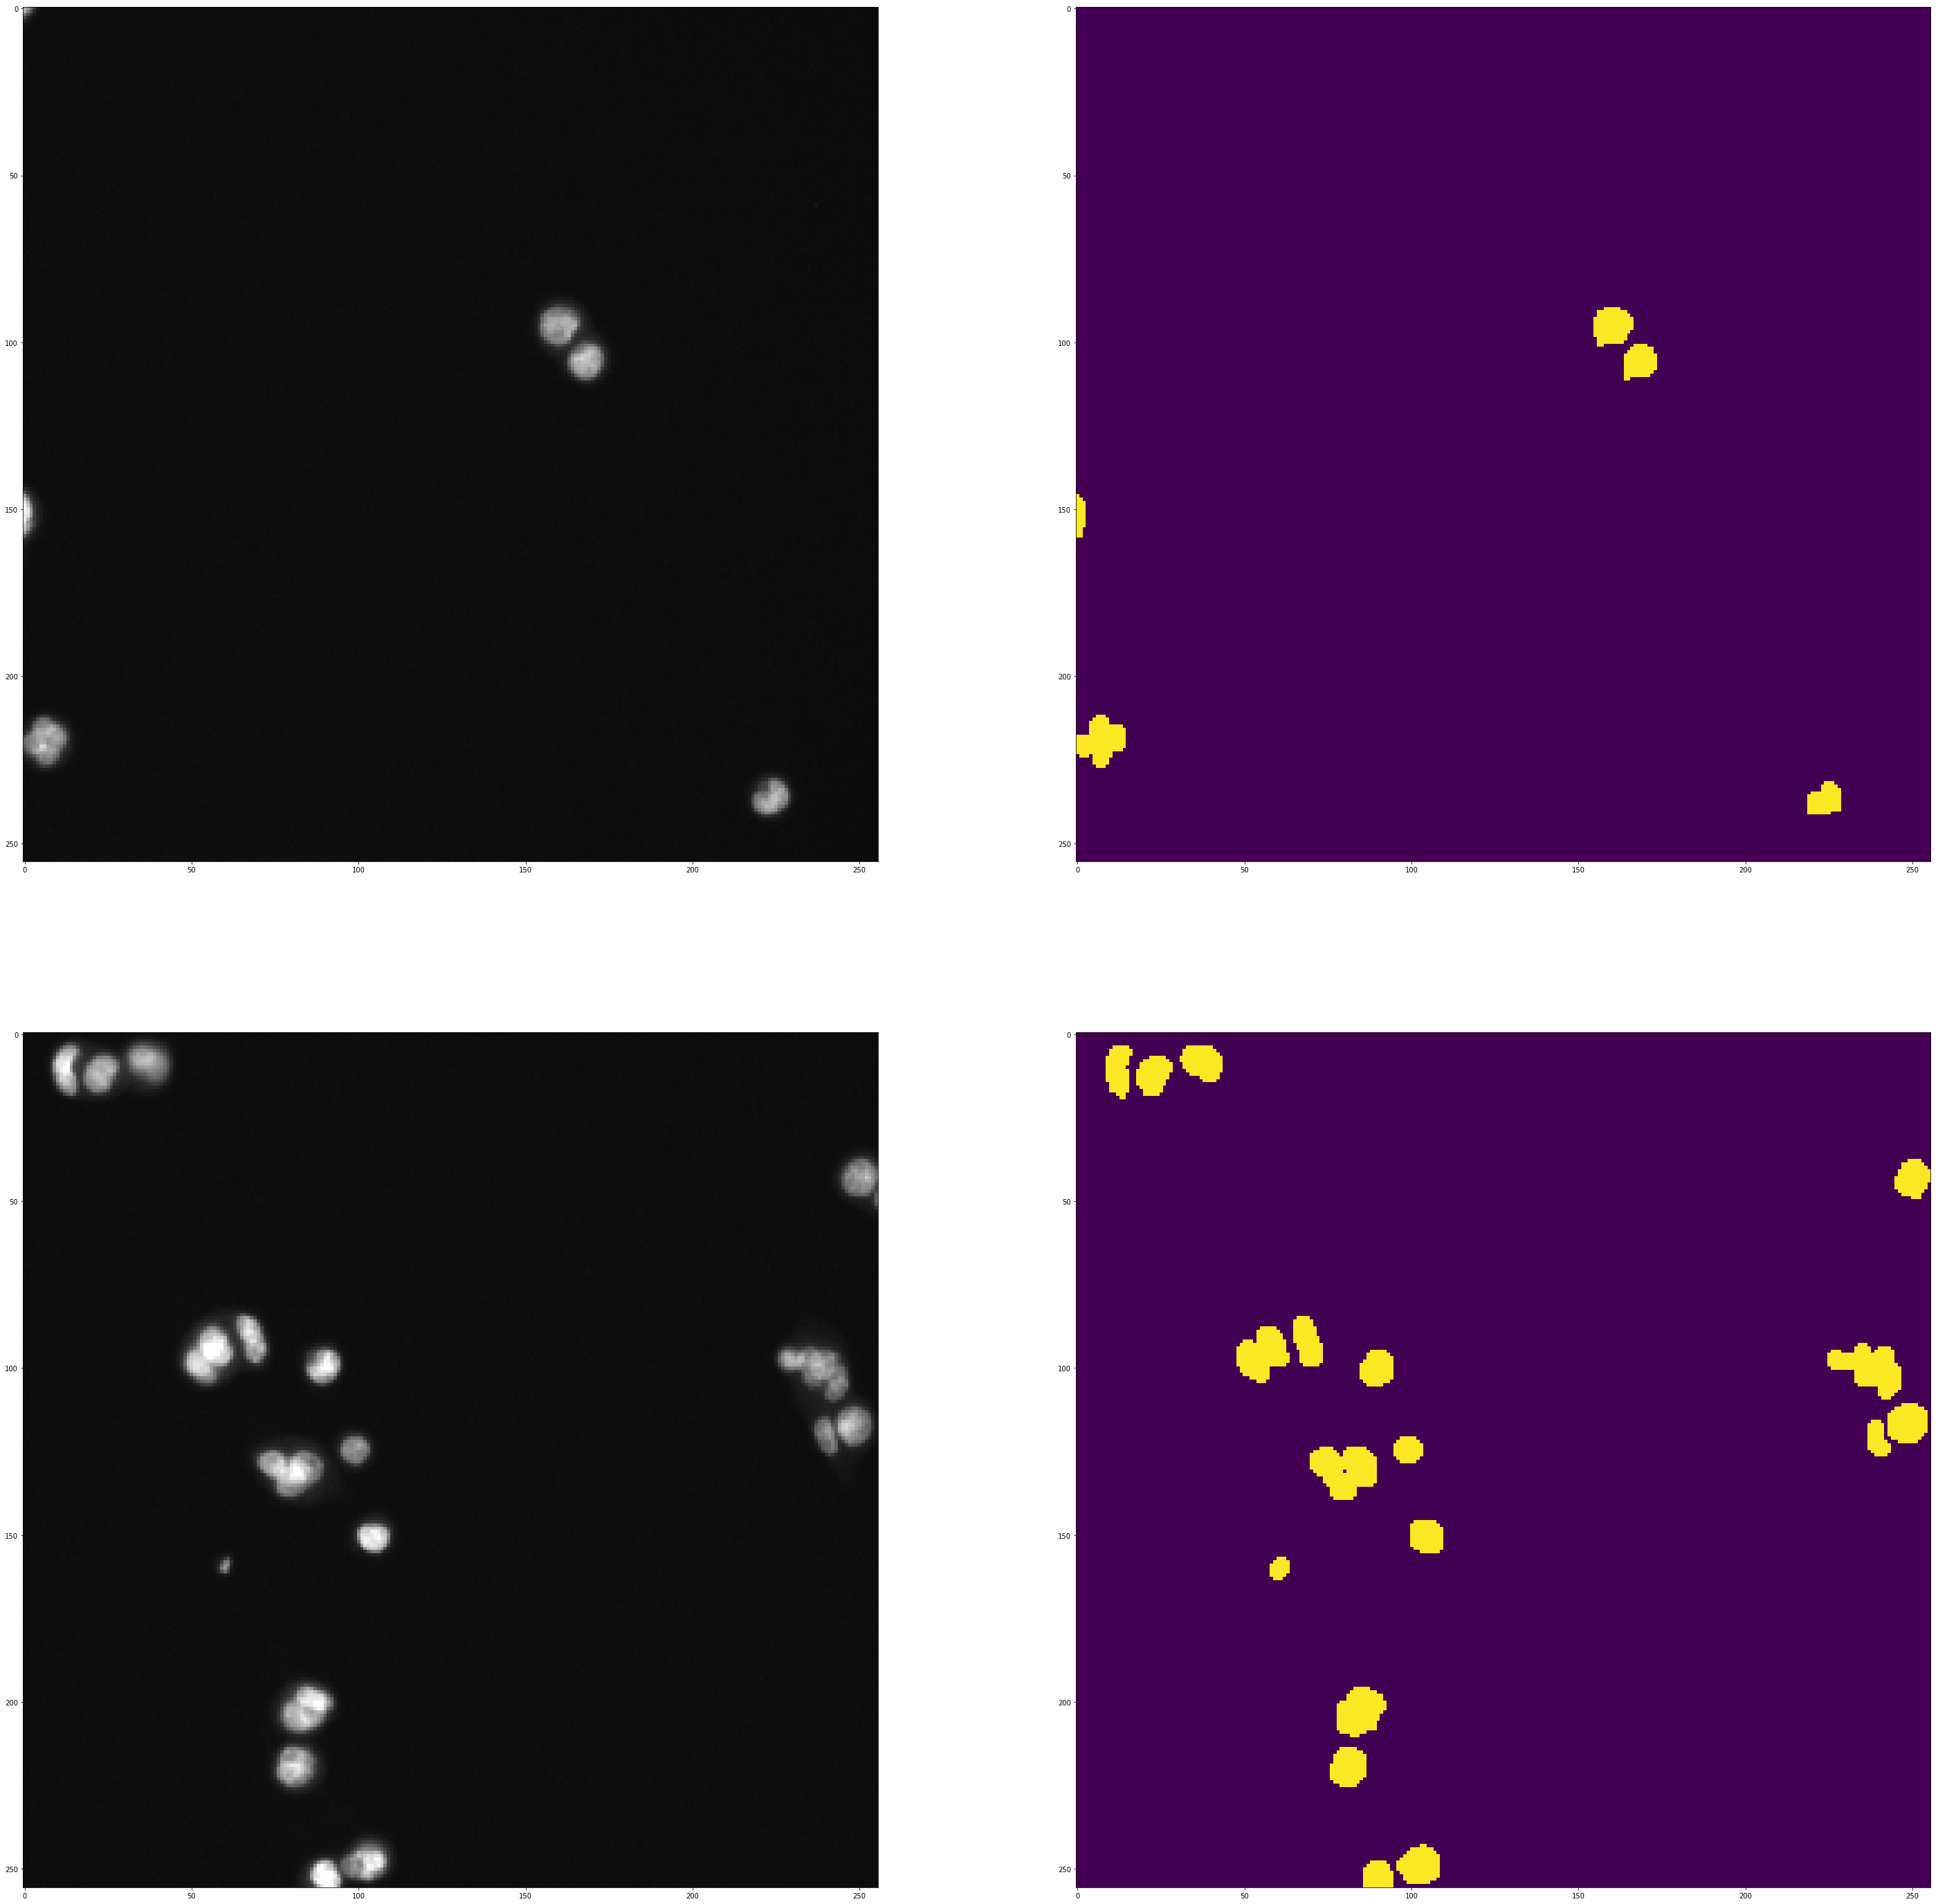

In [8]:
image_ids = os.listdir("../input/data-science-bowl-2018/stage1_train/")
print("Total Images in Training set: {}".format(len(image_ids)))
random_image_ids = random.sample(image_ids, 2)
print("Randomly Selected Images: {}, their IDs: {}".format(len(random_image_ids), random_image_ids))
plot_images_masks(random_image_ids)

## 3. Data Preprocessing and Data Generator
### 3.1 Data Generator functions
##### Variables Declaration

In [9]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../input/data-science-bowl-2018/stage1_train/'
VAL_PATH=TRAIN_PATH
TEST_PATH = "../input/data-science-bowl-2018/stage1_test/"

##### Read Path for files from inputdata directory

In [10]:
# Get train and test IDs
cellimg_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(cellimg_ids, test_size=0.3)

batch_size = 16 #experiment with the batch size

##### Initialize Batch function

In [11]:
def init_batch_data(batch_size):
    batch_data = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),dtype=np.uint8) 
    batch_labels = np.zeros((batch_size,IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels

##### Function to retrieve data in batach

In [12]:
def get_batchdata(source_path, batch_num, batch_size, batch_ids):
    
    batch_data,batch_labels = init_batch_data(batch_size)      
    #for n, id_ in tqdm(enumerate(batch_ids), total=len(batch_ids)):
    for n, id_ in enumerate(batch_ids):
        path = source_path + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        batch_data[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        batch_labels[n] = mask    
        
    return batch_data,batch_labels

##### Data Generator Function

In [13]:
def generator(source_path, imagefile_ids, batch_size,ablation=None):
    print( 'Source path:{} batch size:{} ablation:{}'.format(source_path,batch_size,ablation))
    #print( 'Source path: ', source_path, ' batch size: ', batch_size,' ablation:',ablation)
    
    if(ablation!=None):
        image_ids=imagefile_ids[:ablation]
    else:
        image_ids=imagefile_ids
            
    while True:
        images = np.random.permutation(image_ids)
        num_batches = len(image_ids)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # you yield the batch_data and the batch_labels, remember what does yield do
            #print("\n processing batch:{}".format(batch))
            batch_ids=image_ids[batch*batch_size:(batch*batch_size)+batch_size]
            yield get_batchdata(source_path, batch, batch_size,batch_ids)
            
        
        # Code for the remaining data points which are left after full batches
        if ((len(image_ids)%batch_size) != 0):           
            batch_size_last = len(image_ids) - (batch_size*num_batches)
            batch_ids=image_ids[num_batches*batch_size:(num_batches*batch_size)+batch_size_last]
            yield get_batchdata(source_path, num_batches, batch_size_last, batch_ids) 

##### Calculate Sequences and steps per epoch to disply during training. also create Train and Validation Generator

In [14]:
import datetime
curr_dt_time = datetime.datetime.now()

ablation_train="None"
ablation_test="None"

train_generator = generator(TRAIN_PATH, train_ids, batch_size)
val_generator = generator(VAL_PATH, val_ids, batch_size)

if(ablation_train!="None"):
    num_train_sequences = ablation_train
else:
    num_train_sequences = len(train_ids)
print('# training sequences =', num_train_sequences)

if(ablation_test!="None"):
    num_val_sequences = ablation_test
else:
    num_val_sequences = len(val_ids)
print('# validation sequences =', num_val_sequences)
#------------------------------------------------------
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 469
# validation sequences = 201


Test if Data Generator is working

In [15]:
# batchno=0
# totalrecords=0

# for batch in range(43):
#     batchdata,batchlabel = next(val_generator)
#     totalrecords=totalrecords+len(batchdata)
#     print("batchno:{}".format(batch))
#     print("batchdata:{}".format(len(batchdata)))
#     print("batchlabel:{}".format(len(batchlabel)))
#     print("totalrecords:{}".format(totalrecords))
#     print("------------------------------------")
    
    

## 4. Build Model
##### Define number of epochs

In [16]:
num_epochs =30
print ('# epochs =', num_epochs)

# epochs = 30


##### Define mean iou function for metrics

In [17]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


### 4.1 Build U-Net Model

In [18]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
model = Model(inputs=[inputs], outputs=[outputs])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### 4.2 Compile Model

In [19]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou,'accuracy'])
model.summary()

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
_____________________________________________________________________________________

### 4.3 Define model checkpoints and file name to save model

In [23]:
# model_name = '../input/UNetModels/Trial_meaniou' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
# if not os.path.exists(model_name):
#     os.mkdir(model_name)
model_name = '../input/UNetModels/'
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{acc:.5f}-{val_loss:.5f}-{val_acc:.5f}.h5'

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [earlystopper, checkpoint, LR]
#callbacks_list = [ checkpoint, LR]

### 4.4 Train the Model
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [24]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
Source path:../input/data-science-bowl-2018/stage1_train/ batch size:16 ablation:None
Source path:../input/data-science-bowl-2018/stage1_train/ batch size:16 ablation:None
30/30 [==============================] - 466s 16s/step - loss: 0.6151 - mean_iou: 0.3866 - acc: 0.7746 - val_loss: 0.4576 - val_mean_iou: 0.4020 - val_acc: 0.8037

Epoch 00001: val_loss improved from inf to 0.45755, saving model to ../input/UNetModels/model-00001-0.61395-0.77665-0.45755-0.80365.h5


OSError: Unable to create file (unable to open file: name = '../input/UNetModels/model-00001-0.61395-0.77665-0.45755-0.80365.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

## 5. Make predictions

### 5.1 Load Train and Test Data

##### Load train data. you can change this function if you dont want to load all data

In [ ]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

##### Load Test Data

In [ ]:
print(TEST_PATH)
test_ids_all = next(os.walk(TEST_PATH))[1]
test_ids=test_ids_all[1:10]
print(len(test_ids))

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

### 5.2 Load Model
##### Replace the modelfile path for the model you want to predict the data with

In [ ]:
# Predict on train, val and test
#model = load_model("../input/UNetModels/Trial_meaniou_2019-04-2411_15_20.348759/model-00023-0.07434-0.97033-0.09049-0.96802.h5", custom_objects={'mean_iou':mean_iou})

##### Predict Cell Segmentation

In [ ]:
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

##### Plot Random images train image, true label and predicted label

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

##### Plot Random images test image  predicted label

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()